# Data extraction and processing: SMHI weather data

Author: Jakob Nyström

In [41]:
import requests
import json
import pandas as pd
import pyproj
from geopy.distance import geodesic
import csv
from datetime import datetime
from io import StringIO
from math import ceil
import matplotlib.pyplot as plt

In [42]:
import jupyter_black

jupyter_black.load()

## 1. Find available stations for parameters of interest

Not all stations have records of all weather parameters. We are interested in daily average temperature (2), daily precipitation (5) and daily average irradiance (11). 

In [43]:
# Function to extract required data from each station in the JSON object
def extract_station_data(url):
    try:
        # Send request and get data in json format
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        # Extract the required information for each station
        stations = []
        for station in data["station"]:
            station_data = {
                "Name": station.get("name"),
                "Owner": station.get("owner"),
                "Owner category": station.get("ownerCategory"),
                "Station type": station.get("measuringStations"),
                "Id": station.get("id"),
                "Altitude": station.get("height"),
                "Latitude": station.get("latitude"),
                "Longitude": station.get("longitude"),
                "Active": station.get("active"),
            }
            stations.append(station_data)

        # Return the information as a dataframe
        return pd.DataFrame(stations)

    except requests.RequestException as e:
        return f"Error: {e}"

In [44]:
# Get stations that have daily average temp
url = "https://opendata-download-metobs.smhi.se/api/version/latest/parameter/2.json"
df_temp_stations = extract_station_data(url)
df_temp_stations.head()

,Name,Owner,Owner category,Station type,Id,Altitude,Latitude,Longitude,Active
0,Abelvattnet Aut,SMHI,CLIMATE,CORE,154860,665.000,65.5300,14.9700,False
1,Abisko,SMHI,CLIMATE,CORE,188800,393.380,68.3538,18.8166,False
2,Abisko Aut,Polarforskningssekretariatet,CLIMATE,CORE,188790,392.303,68.3538,18.8164,True
3,Abraur,SMHI,CLIMATE,CORE,158990,368.079,65.9857,18.9195,False
4,Adelsnäs,SMHI,CLIMATE,CORE,85600,97.000,58.1998,15.9802,False


In [45]:
df_temp_stations.shape

(914, 9)

In [46]:
# Get stations that have daily precipitation
url = "https://opendata-download-metobs.smhi.se/api/version/latest/parameter/5.json"
df_precip_stations = extract_station_data(url)
df_precip_stations.head()

,Name,Owner,Owner category,Station type,Id,Altitude,Latitude,Longitude,Active
0,Aapua,SMHI,CLIMATE,CORE,173010,210.00,66.8656,23.4951,False
1,Abborrberg,SMHI,CLIMATE,CORE,157010,550.00,65.4833,16.6000,False
2,Abelvattnet Aut,SMHI,CLIMATE,CORE,154860,665.00,65.5300,14.9700,False
3,Abild,SMHI,CLIMATE,CORE,62570,145.00,56.9512,12.7909,False
4,Abisko,SMHI,CLIMATE,CORE,188800,393.38,68.3538,18.8166,False


In [47]:
df_precip_stations.shape

(2105, 9)

## 2. Match SMHI weather stations to lakes based on coordinates

In [48]:
# Load lakes dataset
df_lake = pd.read_csv("../data/lake_chem_data_clean.csv")
df_lake.head()

,MD-MVM Id,Survey station,Latitude,Longitude,County,Municipality,MS_CD C3,Sample date,Sample year,Sample month,...,Oxygen (mg/l O2),Secchi depth (m),Secchi depth binoculars (m),Secchi depth no binoculars (m),Water temp (°C),Tot-N (µg/l N),Abs_F 420 (/m),SUVA_254 (/m),TOC:TON (mol/l),TOC:TOP (mol/l)
0,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-03-28,2001,3,...,NaN,5.5,NaN,NaN,0.6,409.0,1.06,NaN,61.513265,7809.079772
1,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-05-21,2001,5,...,NaN,7.6,NaN,NaN,10.2,360.0,1.02,NaN,37.362236,10571.725918
2,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-08-22,2001,8,...,NaN,6.0,NaN,NaN,18.6,195.0,0.58,NaN,107.185530,21916.992757
3,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-10-15,2001,10,...,NaN,7.0,NaN,NaN,10.3,383.0,0.70,NaN,28.417294,7391.613243
4,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2002-02-26,2002,2,...,NaN,NaN,NaN,NaN,1.5,385.0,0.70,NaN,55.161258,7072.374133


In [49]:
df_lake.shape

(8974, 47)

In [50]:
# Only keep columns from lake data that we need for joins
df_lake = df_lake[
    ["MD-MVM Id", "Survey station", "Latitude", "Longitude", "Sample date"]
]
df_lake.head()

,MD-MVM Id,Survey station,Latitude,Longitude,Sample date
0,54,Spjutsjön,60.638793,15.445276,2001-03-28
1,54,Spjutsjön,60.638793,15.445276,2001-05-21
2,54,Spjutsjön,60.638793,15.445276,2001-08-22
3,54,Spjutsjön,60.638793,15.445276,2001-10-15
4,54,Spjutsjön,60.638793,15.445276,2002-02-26


In [51]:
df_lake.shape

(8974, 5)

In [52]:
# Filter SMHI data to keep only active stations
df_temp_stations = df_temp_stations.loc[df_temp_stations["Active"] == True]
df_precip_stations = df_precip_stations.loc[df_precip_stations["Active"] == True]
print(df_temp_stations.shape, df_precip_stations.shape)

(239, 9) (591, 9)


In [53]:
# Function to calculate Haversine distance between two sets of coordinates
def haversine_distance(coord_1, coord_2):
    distance = geodesic(coord_1, coord_2).kilometers
    return round(distance, 1)

In [54]:
def find_closest_station(df_lake, df_other, parameter):
    # Iterate through each station in lake data and calculate
    # distance to SMHI stations in other dataframe
    for index, row in df_lake.iterrows():
        distances = df_other.apply(
            lambda x: haversine_distance(
                (row["Latitude"], row["Longitude"]), (x["Latitude"], x["Longitude"])
            ),
            axis=1,
        )

        # Select the SMHI stations with shortest distance
        min_distance_idx = distances.idxmin()
        closest_station = df_other.loc[min_distance_idx, "Id"]
        df_lake.at[index, f"{parameter} station id"] = closest_station.astype(int)
        df_lake.at[index, f"{parameter} station dist"] = distances[min_distance_idx]

    # Join in name of SMHI stations
    df_lake = df_lake.join(
        df_other[["Id", "Name"]].set_index("Id"), on=f"{parameter} station id"
    ).rename(columns={"Name": f"{parameter} station name"})
    df_lake[f"{parameter} station id"] = df_lake[f"{parameter} station id"].astype(int)

    return df_lake

### Match closest stations that have temperature data 

In [55]:
df_lake_temp = find_closest_station(df_lake, df_temp_stations, parameter="Temp")
df_lake_temp.head()

,MD-MVM Id,Survey station,Latitude,Longitude,Sample date,Temp station id,Temp station dist,Temp station name
0,54,Spjutsjön,60.638793,15.445276,2001-03-28,105370,11.8,Falun-Lugnet
1,54,Spjutsjön,60.638793,15.445276,2001-05-21,105370,11.8,Falun-Lugnet
2,54,Spjutsjön,60.638793,15.445276,2001-08-22,105370,11.8,Falun-Lugnet
3,54,Spjutsjön,60.638793,15.445276,2001-10-15,105370,11.8,Falun-Lugnet
4,54,Spjutsjön,60.638793,15.445276,2002-02-26,105370,11.8,Falun-Lugnet


In [56]:
# Check deviations between lake and closest station
print(f"Mean: {df_lake['Temp station dist'].mean()}")
print(f"Min: {df_lake['Temp station dist'].min()}")
print(f"Max: {df_lake['Temp station dist'].max()}")

Mean: 21.738087809226652
Min: 1.0
Max: 48.0


In [57]:
df_lake.shape

(8974, 7)

### Match closest stations that have precipitation data 

In [ ]:
df_lake_precip = find_closest_station(
    df_lake_temp, df_precip_stations, parameter="Precip"
)
df_lake_precip.head()

In [59]:
df_lake.shape

(8974, 7)

In [78]:
# Add the temperature station coordinates
df_temp_stations = df_temp_stations.rename(
    columns={"Latitude": "Temp station lat", "Longitude": "Temp station long"}
)
df_lake = df_lake_precip.join(
    df_temp_stations[["Id", "Temp station lat", "Temp station long"]].set_index("Id"),
    on="Temp station id",
)

# Add the precipitation station coordinates
df_precip_stations = df_precip_stations.rename(
    columns={"Latitude": "Precip station lat", "Longitude": "Precip station long"}
)
df_lake = df_lake.join(
    df_precip_stations[["Id", "Precip station lat", "Precip station long"]].set_index(
        "Id"
    ),
    on="Precip station id",
)
df_lake.head()

,MD-MVM Id,Survey station,Latitude,Longitude,Sample date,Temp station id,Temp station dist,Temp station name,Precip station id,Precip station dist,Precip station name,Temp station lat,Temp station long,Precip station lat,Precip station long
0,54,Spjutsjön,60.638793,15.445276,2001-03-28,105370,11.8,Falun-Lugnet,105470,11.7,Bjursås,60.6185,15.6574,60.7438,15.4625
1,54,Spjutsjön,60.638793,15.445276,2001-05-21,105370,11.8,Falun-Lugnet,105470,11.7,Bjursås,60.6185,15.6574,60.7438,15.4625
2,54,Spjutsjön,60.638793,15.445276,2001-08-22,105370,11.8,Falun-Lugnet,105470,11.7,Bjursås,60.6185,15.6574,60.7438,15.4625
3,54,Spjutsjön,60.638793,15.445276,2001-10-15,105370,11.8,Falun-Lugnet,105470,11.7,Bjursås,60.6185,15.6574,60.7438,15.4625
4,54,Spjutsjön,60.638793,15.445276,2002-02-26,105370,11.8,Falun-Lugnet,105470,11.7,Bjursås,60.6185,15.6574,60.7438,15.4625


In [79]:
# Check deviations between lake and closest station
print(f"Mean: {df_lake['Precip station dist'].mean()}")
print(f"Min: {df_lake['Precip station dist'].min()}")
print(f"Max: {df_lake['Precip station dist'].max()}")

Mean: 13.067238689547581
Min: 1.0
Max: 45.4


In [80]:
df_lake.shape

(8974, 15)

In [63]:
# Check individual stations and their matches
df_lake.loc[df_lake["Survey station"] == "V. Rännöbodsjön"]

,MD-MVM Id,Survey station,Latitude,Longitude,Sample date,Temp station id,Temp station dist,Temp station name,Precip station id,Precip station dist,Precip station name,Temp station lat,Temp station long,Precip station lat,Precip station long
6620,134,V. Rännöbodsjön,62.330102,16.987209,2001-02-15,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6621,134,V. Rännöbodsjön,62.330102,16.987209,2001-05-17,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6622,134,V. Rännöbodsjön,62.330102,16.987209,2001-08-16,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6623,134,V. Rännöbodsjön,62.330102,16.987209,2001-10-24,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6624,134,V. Rännöbodsjön,62.330102,16.987209,2002-02-20,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6702,134,V. Rännöbodsjön,62.330102,16.987209,2021-08-03,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6703,134,V. Rännöbodsjön,62.330102,16.987209,2021-10-21,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6704,134,V. Rännöbodsjön,62.330102,16.987209,2022-02-15,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027
6705,134,V. Rännöbodsjön,62.330102,16.987209,2022-05-09,127310,31.9,Sundsvall-Timrå Flygplats,2222812,2.6,Bällsta,62.5246,17.441,62.3446,17.027


## 3. Get SMHI data for the matching weather stations

In [64]:
def download_csv_data(station_id, parameter):
    # Base URL for SMHI Open Data API
    BASE_URL = "https://opendata-download-metobs.smhi.se/api/version/latest"

    endpoint = f"{BASE_URL}/parameter/{parameter}/station/{station_id}/period/corrected-archive/data.csv"
    response = requests.get(endpoint)

    if parameter == 2:
        param_col_header = "Temp (°C)"
    else:
        param_col_header = "Precip (mm)"

    if response.status_code == 200:
        # Store returned data in dataframe
        data = StringIO(response.text)
        df = pd.read_csv(
            data,
            sep=";",
            skiprows=50,
            usecols=[2, 3, 4],
            names=["Date", param_col_header, "Quality"],
        )
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.loc[(df["Date"] >= "2000-01-01") & (df["Date"] <= "2022-12-31")]
        return df
    else:
        print(
            f"Failed to fetch data for station {station_id} and parameter {parameter}"
        )
        return None

In [65]:
# Download and store temperature data
all_data = []
temp_stations = df_lake["Temp station id"].unique()

for station in temp_stations:
    df = download_csv_data(station, 2)
    if df is not None:
        df["Temp station id"] = station
        all_data.append(df)

# Combine all DataFrames into a single DataFrame
df_temp = pd.concat(all_data, ignore_index=True)
df_temp.head()

,Date,Temp (°C),Quality,Temp station id
0,2000-01-01,-9.2,Y,105370
1,2000-01-02,-0.1,Y,105370
2,2000-01-03,-3.2,Y,105370
3,2000-01-04,2.4,Y,105370
4,2000-01-05,-5.5,Y,105370


In [66]:
df_temp.dtypes

Date               datetime64[ns]
Temp (°C)                 float64
Quality                    object
Temp station id             int64
dtype: object

In [67]:
# Download and store precipitation data
all_data = []
precip_stations = df_lake["Precip station id"].unique()

for station in precip_stations:
    df = download_csv_data(station, 5)
    if df is not None:
        df["Precip station id"] = station
        all_data.append(df)

# Combine all DataFrames into a single DataFrame
df_precip = pd.concat(all_data, ignore_index=True)
df_precip.head()

,Date,Precip (mm),Quality,Precip station id
0,2016-07-10,2.8,G,105470
1,2016-07-11,16.2,G,105470
2,2016-07-12,3.8,G,105470
3,2016-07-13,18.7,G,105470
4,2016-07-14,21.1,G,105470


In [68]:
df_precip.dtypes

Date                 datetime64[ns]
Precip (mm)                 float64
Quality                      object
Precip station id             int64
dtype: object

## 4. Join temperature and precipitation data with lake data

In [69]:
# Calculate rolling average temperatures and
# rolling cumulative precipitation

# Select time windows
weeks = [1, 2, 4, 12, 52]

# Sort dataframes by date
df_temp = df_temp.sort_values(by=["Temp station id", "Date"])
df_precip = df_precip.sort_values(by=["Precip station id", "Date"])

# Iterate through all windows
for w in weeks:
    # Rolling average temperatures
    df_temp[f"Temp {w}w avg"] = (
        df_temp.groupby("Temp station id")["Temp (°C)"]
        .rolling(w * 7, min_periods=w * 7)
        .mean()
        .reset_index(drop=True)
        .values
    )
    df_temp = df_temp.sort_values(by=["Temp station id", "Date"]).reset_index(drop=True)

    # Rolling average daily precipitation
    df_precip[f"Precip {w}w avg"] = (
        df_precip.groupby("Precip station id")["Precip (mm)"]
        .rolling(w * 7, min_periods=w * 7)
        .mean()
        .reset_index(drop=True)
        .values
    )
    df_precip = df_precip.sort_values(by=["Precip station id", "Date"]).reset_index(
        drop=True
    )

In [70]:
df_temp.head(20)

,Date,Temp (°C),Quality,Temp station id,Temp 1w avg,Temp 2w avg,Temp 4w avg,Temp 12w avg,Temp 52w avg
0,2008-01-01,0.4,Y,53300,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,0.7,Y,53300,NaN,NaN,NaN,NaN,NaN
2,2008-01-03,-2.8,Y,53300,NaN,NaN,NaN,NaN,NaN
3,2008-01-04,-3.0,Y,53300,NaN,NaN,NaN,NaN,NaN
4,2008-01-05,-1.5,Y,53300,NaN,NaN,NaN,NaN,NaN
5,2008-01-06,1.4,Y,53300,NaN,NaN,NaN,NaN,NaN
6,2008-01-07,1.7,Y,53300,-0.442857,NaN,NaN,NaN,NaN
7,2008-01-08,4.0,Y,53300,0.071429,NaN,NaN,NaN,NaN
8,2008-01-09,3.6,Y,53300,0.485714,NaN,NaN,NaN,NaN
9,2008-01-10,4.0,Y,53300,1.457143,NaN,NaN,NaN,NaN


In [71]:
df_precip.head(20)

,Date,Precip (mm),Quality,Precip station id,Precip 1w avg,Precip 2w avg,Precip 4w avg,Precip 12w avg,Precip 52w avg
0,2000-01-01,1.6,G,53230,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,0.2,G,53230,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,0.3,G,53230,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,8.3,G,53230,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,0.0,G,53230,NaN,NaN,NaN,NaN,NaN
5,2000-01-06,1.9,G,53230,NaN,NaN,NaN,NaN,NaN
6,2000-01-07,0.0,G,53230,1.757143,NaN,NaN,NaN,NaN
7,2000-01-08,0.0,G,53230,1.528571,NaN,NaN,NaN,NaN
8,2000-01-09,0.0,G,53230,1.500000,NaN,NaN,NaN,NaN
9,2000-01-10,0.0,G,53230,1.457143,NaN,NaN,NaN,NaN


In [81]:
# Join temp and precip data to dataframe with lake observations

df_lake["Sample date"] = pd.to_datetime(df_lake["Sample date"])

# Temperature data
df_lake = df_lake.join(
    df_temp.drop(["Temp (°C)", "Quality"], axis="columns").set_index(
        ["Temp station id", "Date"]
    ),
    on=["Temp station id", "Sample date"],
    how="left",
)
df_lake.head()

# Precipitation data
df_lake = df_lake.join(
    df_precip.drop(["Precip (mm)", "Quality"], axis="columns").set_index(
        ["Precip station id", "Date"]
    ),
    on=["Precip station id", "Sample date"],
    how="left",
)
df_lake.head()

,MD-MVM Id,Survey station,Latitude,Longitude,Sample date,Temp station id,Temp station dist,Temp station name,Precip station id,Precip station dist,...,Temp 1w avg,Temp 2w avg,Temp 4w avg,Temp 12w avg,Temp 52w avg,Precip 1w avg,Precip 2w avg,Precip 4w avg,Precip 12w avg,Precip 52w avg
0,54,Spjutsjön,60.638793,15.445276,2001-03-28,105370,11.8,Falun-Lugnet,105470,11.7,...,-5.285714,-5.635714,-4.192857,-5.066667,5.641209,NaN,NaN,NaN,NaN,NaN
1,54,Spjutsjön,60.638793,15.445276,2001-05-21,105370,11.8,Falun-Lugnet,105470,11.7,...,8.985714,11.342857,9.578571,2.153571,5.380220,NaN,NaN,NaN,NaN,NaN
2,54,Spjutsjön,60.638793,15.445276,2001-08-22,105370,11.8,Falun-Lugnet,105470,11.7,...,16.700000,15.857143,15.828571,15.752381,5.734890,NaN,NaN,NaN,NaN,NaN
3,54,Spjutsjön,60.638793,15.445276,2001-10-15,105370,11.8,Falun-Lugnet,105470,11.7,...,8.914286,9.371429,8.985714,12.829762,5.856319,NaN,NaN,NaN,NaN,NaN
4,54,Spjutsjön,60.638793,15.445276,2002-02-26,105370,11.8,Falun-Lugnet,105470,11.7,...,-5.842857,-2.942857,-1.850000,-4.617857,5.262912,NaN,NaN,NaN,NaN,NaN


In [82]:
df_lake.shape

(8974, 25)

## 5. Validate data availability

In [87]:
# Function to generate and save plots for a specific lake and set of variables
def generate_data_availability_plots(lake_id, ax):
    # Filter data for the specific lake
    lake_data = df_lake[df_lake["MD-MVM Id"] == lake_id]
    lake_data = lake_data.sort_values(by="Sample date")

    # Plot 52w average temperature on the first axis
    ax.plot(lake_data.index, lake_data["Temp 52w avg"], color="b")

    # Create a second y-axis for the second variable
    ax2 = ax.twinx()
    ax2.plot(lake_data.index, lake_data["Precip 52w avg"], color="r")

    # Set a title for the plot
    ax.set_title(f"{lake_id}: {lake_data['Survey station'].unique()}")

    # Remove x and y-axis tick numbers
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])

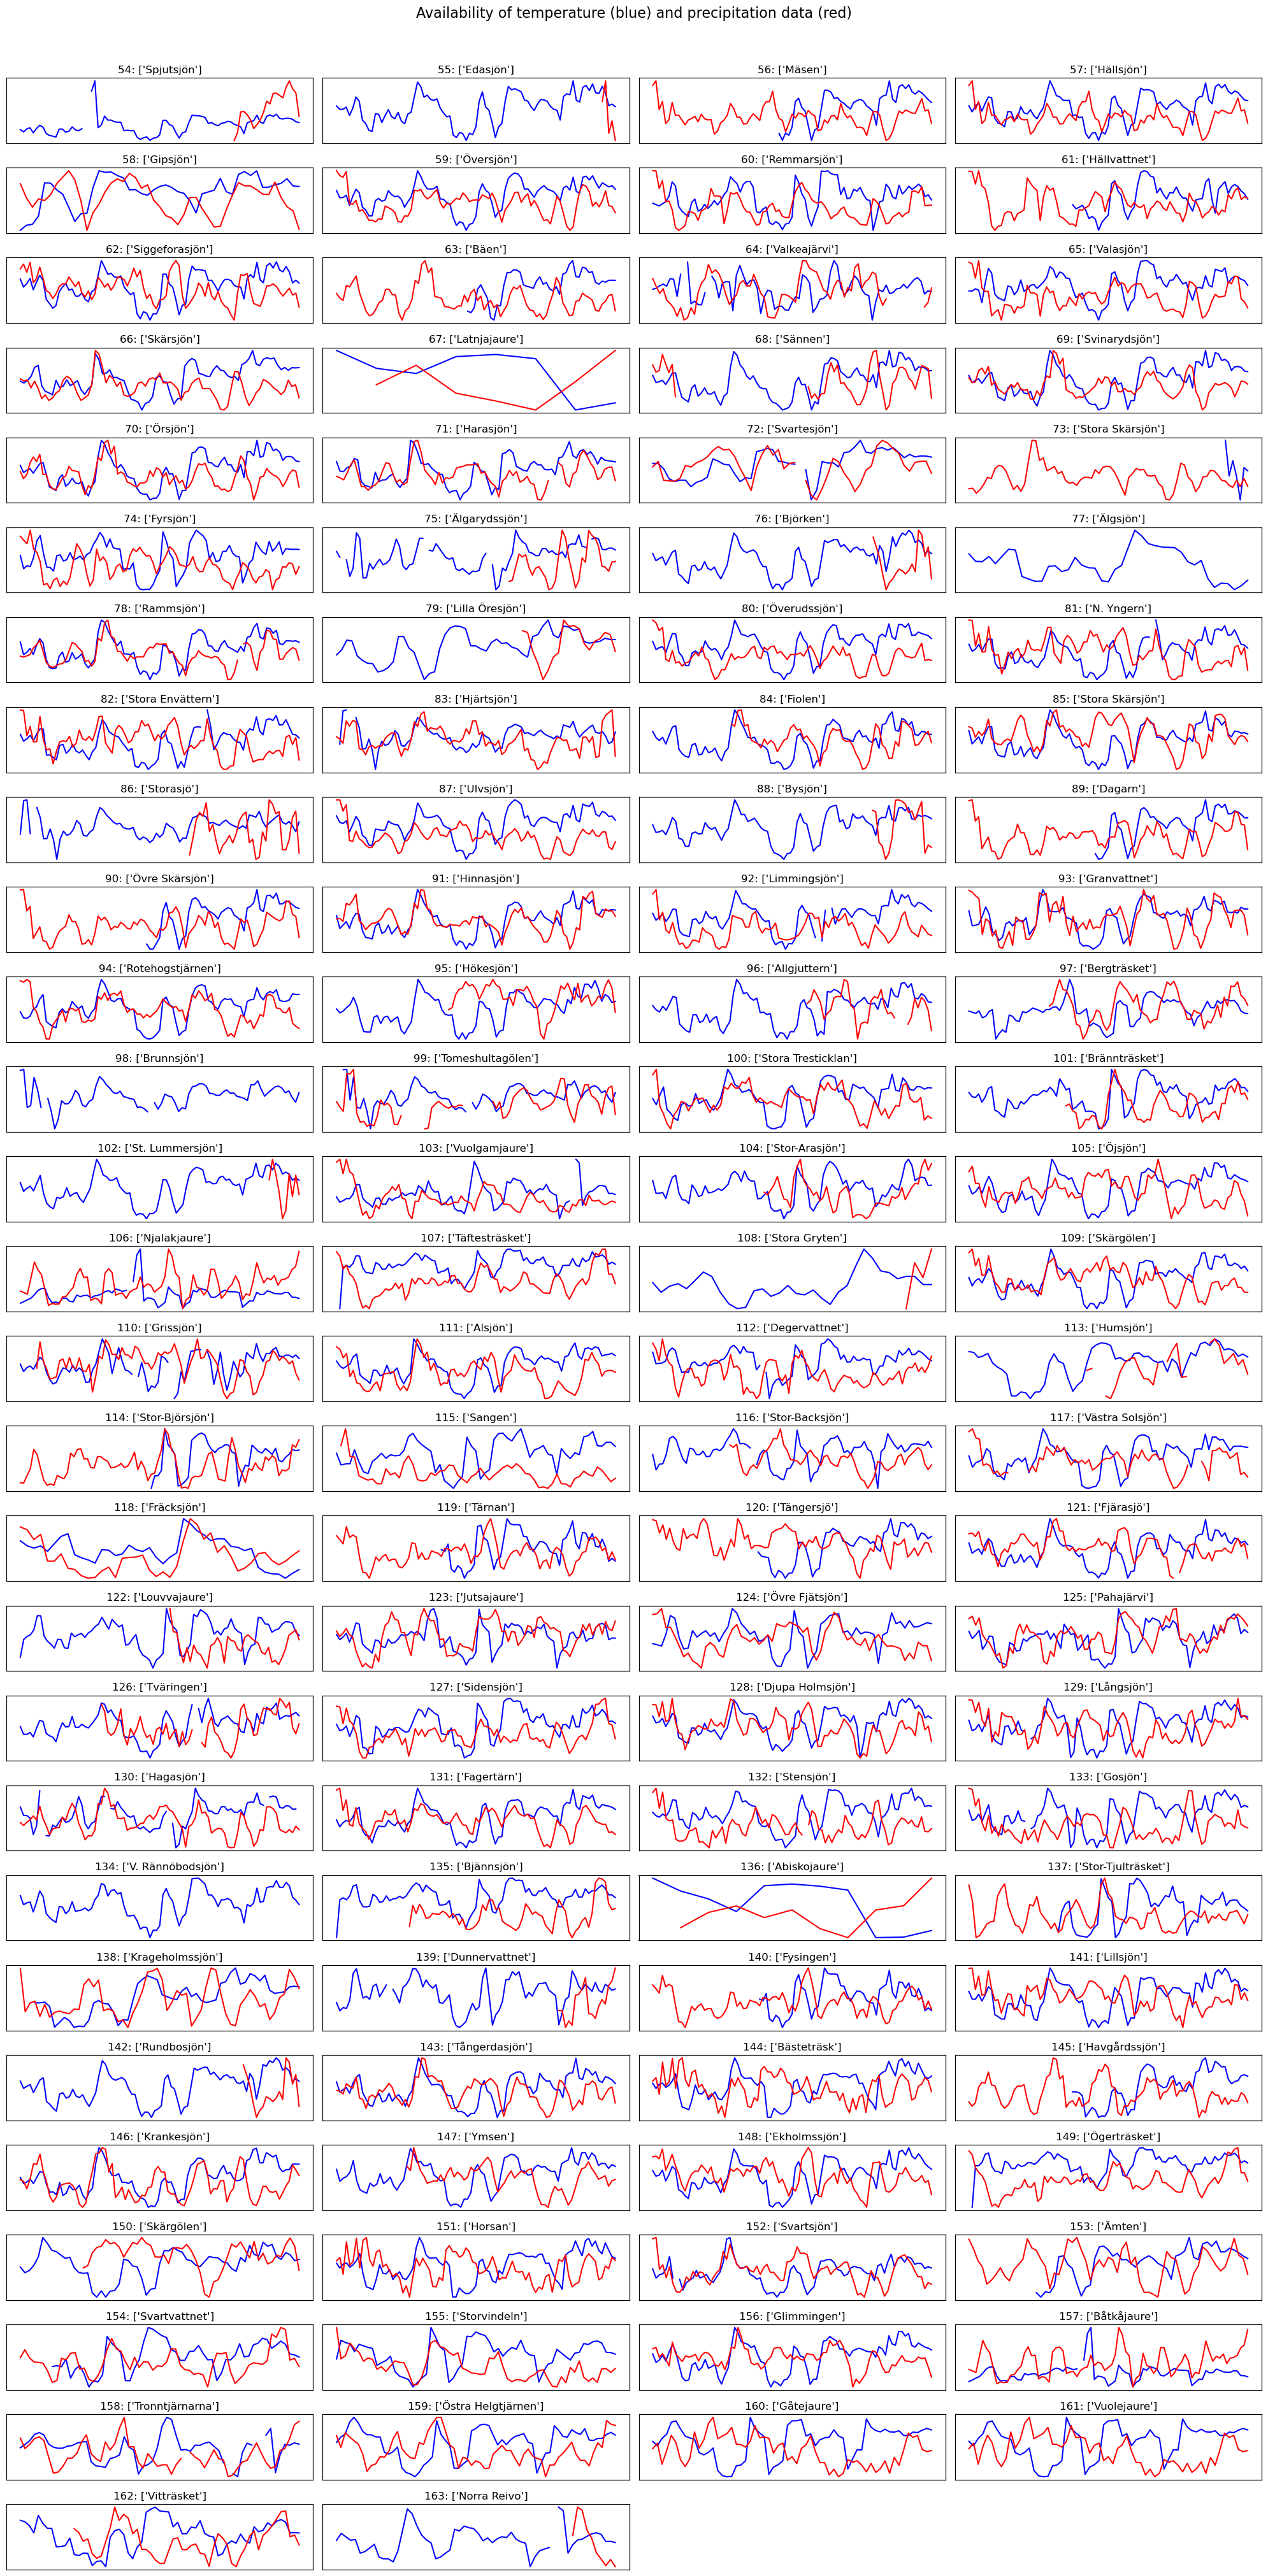

In [88]:
list_of_lakes = list(df_lake["MD-MVM Id"].unique())

# Calculate the number of rows and columns for the subplot grid
num_lakes = len(list_of_lakes)
num_cols = 4
num_rows = ceil(num_lakes / num_cols)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 40))

# Generate and save plots for each lake in the subplot grid
for i, lake_id in enumerate(list_of_lakes):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    generate_data_availability_plots(lake_id, ax)

# Remove empty subplots
for i in range(len(list_of_lakes), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

fig.suptitle(
    "Availability of temperature (blue) and precipitation data (red)",
    y=1.01,
    fontsize=16,
)
plt.tight_layout()

plt.show()

In [95]:
df_lake.groupby("MD-MVM Id")

In [122]:
def generate_nan_plots(groupby):
    result = grouped[column].agg(nan_share)
    ax.hist(result, bins=20, color="skyblue")
    ax.set_title(f"{column}")

    # Remove x and y-axis tick numbers
    ax.set_xticks([])
    ax.set_yticks([])

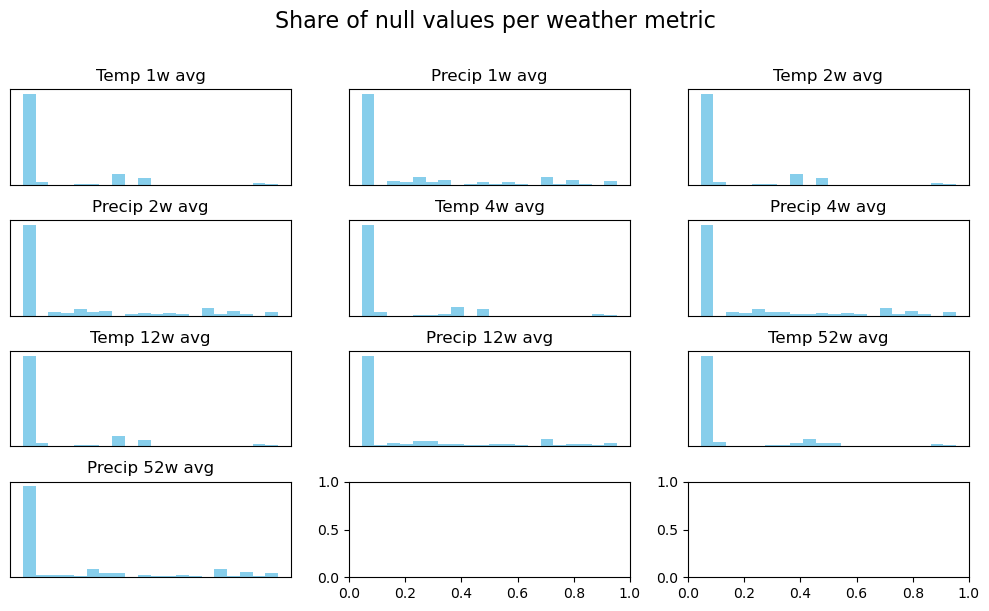

In [124]:
grouped = df_lake.groupby("MD-MVM Id")

cols_to_check = [
    "Temp 1w avg",
    "Precip 1w avg",
    "Temp 2w avg",
    "Precip 2w avg",
    "Temp 4w avg",
    "Precip 4w avg",
    "Temp 12w avg",
    "Precip 12w avg",
    "Temp 52w avg",
    "Precip 52w avg",
]


def nan_share(column):
    return column.isna().mean()


# Calculate the number of rows and columns for the subplot grid
num_lakes = len(cols_to_check)
num_cols = 3
num_rows = ceil(num_lakes / num_cols)

# Create histograms to show the share of nan values
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

# Plot histograms for the share of NaN values for each variable
for i, column in enumerate(cols_to_check):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    generate_nan_plots(grouped)

# Remove empty subplots
for i in range(len(list_of_lakes), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

fig.suptitle(
    "Share of null values per weather metric",
    y=1.01,
    fontsize=16,
)

plt.tight_layout()
plt.show()

## 6. Save data

In [125]:
# Save the file in the data folder
df_lake.to_csv("../data/weather_data_clean.csv", index=False)